In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260125_control.csv"
DATE_COL = "experiment_date"

TARGET_WEEKS = [pd.Timestamp("2026-01-05")]

Y_COLS = ["nonrepeat_cnt_per_user", "trip_cnt_per_user"]

CAT_COLS = ["ops_type_merged", "city_group"]

NUM_FEATURES = [
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "nonrepeat_cnt_per_user_lag2",
    "nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2",
    "trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2",
    "weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2",
    "weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2",
    "weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2",
    "weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2",
    "weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2",
    "weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2",
    "coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2",
    "coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2",
    "coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2",
    "coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2",
    "coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2",
    "coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2",
    "coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2",
    "coupon_daily_per_user_log1p_roll4",
    "delta_trip_per_user",
    "delta_nonrepeat_per_user",
]

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()

# 只保留到最大 target week 為止（後面不會用到）
df = df[df[DATE_COL] <= max(TARGET_WEEKS)].copy()

# categorical cast
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check
missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred) -> float:
    return float(mean_absolute_error(y_true, y_pred))

def fit_predict_one_week(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str):
    # 嚴格遵守：只能拿 target_week 之前的資料訓練
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    # drop rows with missing target
    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=3600,
        learning_rate=0.05,
        num_leaves=35,
        min_child_samples=20,
        subsample=1.0,
        colsample_bytree=0.7,
        bagging_freq=0,
        reg_alpha=0.4,
        reg_lambda=7.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )

    # categorical_feature: 用欄名即可
    model.fit(X_train, y_train, categorical_feature=[c for c in CAT_IN_X if c in X_train.columns])

    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

# --------------------------
# Run + Print metrics
# --------------------------
for y_col in Y_COLS:
    print(f"\n==================== {y_col} ====================")
    all_y_true = []
    all_y_pred = []

    for tw in TARGET_WEEKS:
        y_true, y_pred, n_tr, n_te = fit_predict_one_week(df, tw, y_col)
        if y_true is None:
            print(f"[{tw.date()}] SKIP (train_rows={n_tr:,}, test_rows={n_te:,})")
            continue

        r = rmse(y_true, y_pred)
        m = mae(y_true, y_pred)
        print(f"[{tw.date()}] train_rows={n_tr:,} test_rows={n_te:,}  RMSE={r:.6f}  MAE={m:.6f}")

        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

    if all_y_true:
        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)
        print(f"[Overall 2 weeks] test_rows={len(all_y_true):,}  RMSE={rmse(all_y_true, all_y_pred):.6f}  MAE={mae(all_y_true, all_y_pred):.6f}")



==================== nonrepeat_cnt_per_user ====================
[2026-01-05] train_rows=528 test_rows=24  RMSE=0.043756  MAE=0.037298
[Overall 2 weeks] test_rows=24  RMSE=0.043756  MAE=0.037298

==================== trip_cnt_per_user ====================
[2026-01-05] train_rows=528 test_rows=24  RMSE=0.025656  MAE=0.021581
[Overall 2 weeks] test_rows=24  RMSE=0.025656  MAE=0.021581


In [6]:
# ==========================
# Optuna tuning for CONTROL
# - Tune separately for each target in Y_COLS
# - Objective: avg RMSE over 2026-01-05
# - Training constraint: ONLY use data strictly before each target week
# - No saving files, just print best + per-week metrics
# ==========================

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ---- baseline params (center of search)
BASE_PARAMS = dict(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=80,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

def fit_predict_one_week_with_params(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str, model_params: dict):
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    model = lgb.LGBMRegressor(**model_params)
    model.fit(
        X_train, y_train,
        categorical_feature=[c for c in CAT_IN_X if c in X_train.columns],
    )
    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

def tune_one_target(y_col: str, n_trials: int = 60):
    def objective(trial: optuna.Trial) -> float:
        params = dict(BASE_PARAMS)

        # --- search space near your baseline (and sensible)
        params["learning_rate"] = trial.suggest_float("learning_rate", 0.02, 0.08, log=True)
        params["n_estimators"]  = trial.suggest_int("n_estimators", 1200, 4500, step=300)

        params["num_leaves"] = trial.suggest_int("num_leaves", 15, 127, step=4)
        params["min_child_samples"] = trial.suggest_int("min_child_samples", 20, 200, step=10)

        params["subsample"] = trial.suggest_float("subsample", 0.65, 1.0, step=0.05)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.05)

        # bagging_freq: keep small (0/1/2/5) - your baseline uses 1
        params["bagging_freq"] = trial.suggest_categorical("bagging_freq", [0, 1, 2, 5])

        # regularization near baseline
        params["reg_alpha"] = trial.suggest_float("reg_alpha", 0.0, 3.0)
        params["reg_lambda"] = trial.suggest_float("reg_lambda", 0.0, 8.0)

        rmses = []
        for i, tw in enumerate(TARGET_WEEKS, start=1):
            y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, tw, y_col, params)
            if y_true is None or len(y_true) == 0:
                return 1e9
            rmses.append(rmse(y_true, y_pred))

            trial.report(float(np.mean(rmses)), step=i)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(rmses))

    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=0)
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n===== Optuna Best ({y_col}) =====")
    print("Best RMSE (avg over 2 weeks):", study.best_value)
    print("Best params:", study.best_params)

    best_params = dict(BASE_PARAMS)
    best_params.update(study.best_params)

    # ---- evaluate best params with RMSE + MAE per-week + overall
    print(f"\n==================== {y_col} (BEST params) ====================")
    all_y_true, all_y_pred = [], []
    for tw in TARGET_WEEKS:
        y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, tw, y_col, best_params)
        if y_true is None:
            print(f"[{tw.date()}] SKIP (train_rows={n_tr:,}, test_rows={n_te:,})")
            continue
        print(f"[{tw.date()}] train_rows={n_tr:,} test_rows={n_te:,} RMSE={rmse(y_true, y_pred):.6f} MAE={mae(y_true, y_pred):.6f}")
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

    if all_y_true:
        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)
        print(f"[Overall 2 weeks] test_rows={len(all_y_true):,} RMSE={rmse(all_y_true, all_y_pred):.6f} MAE={mae(all_y_true, all_y_pred):.6f}")

    return study


# --------------------------
# Run tuning separately for two targets
# --------------------------
study_trip = tune_one_target("trip_cnt_per_user", n_trials=60)
study_nonrepeat = tune_one_target("nonrepeat_cnt_per_user", n_trials=60)


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (trip_cnt_per_user) =====
Best RMSE (avg over 2 weeks): 0.020734885786763402
Best params: {'learning_rate': 0.02503964047713429, 'n_estimators': 3000, 'num_leaves': 67, 'min_child_samples': 200, 'subsample': 0.8, 'colsample_bytree': 0.7, 'bagging_freq': 0, 'reg_alpha': 0.49666884415613355, 'reg_lambda': 1.5873151943604324}

==================== trip_cnt_per_user (BEST params) ====================
[2026-01-05] train_rows=528 test_rows=24 RMSE=0.020735 MAE=0.016294
[Overall 2 weeks] test_rows=24 RMSE=0.020735 MAE=0.016294


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (nonrepeat_cnt_per_user) =====
Best RMSE (avg over 2 weeks): 0.034601788453631585
Best params: {'learning_rate': 0.062103990206659736, 'n_estimators': 3900, 'num_leaves': 123, 'min_child_samples': 190, 'subsample': 1.0, 'colsample_bytree': 0.65, 'bagging_freq': 1, 'reg_alpha': 0.7800023457843234, 'reg_lambda': 0.5615464967929338}

==================== nonrepeat_cnt_per_user (BEST params) ====================
[2026-01-05] train_rows=528 test_rows=24 RMSE=0.034602 MAE=0.026593
[Overall 2 weeks] test_rows=24 RMSE=0.034602 MAE=0.026593


In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# ==========================
# Build prediction table CSV for 2026-01-05 (CONTROL)
# - Use Optuna best params: study_trip / study_nonrepeat
# - Grain: (experiment_date, ops_type_merged, city_group)
# - Values: actual + baseline(lag1/roll4) + LGBM preds
# - If duplicates: simple mean (unweighted)
# ==========================

# --------------------------
# Config (match your CONTROL script)
# --------------------------
DATA_PATH = "../../final_data/data_260125_control.csv"   # 你的路徑
# 若你在這個 ChatGPT 環境跑，改成：
# DATA_PATH = "/mnt/data/data_260125_control.csv"

DATE_COL = "experiment_date"
TEST_WEEK = pd.Timestamp("2026-01-05")

KEY_COLS = ["experiment_date", "ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# baseline columns (你說沒錯，就用這些)
Y1_LAG1_COL = "trip_cnt_per_user_lag1"
Y1_ROLL4_COL = "trip_cnt_per_user_roll4"
Y2_LAG1_COL = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4_COL = "nonrepeat_cnt_per_user_roll4"

# 你的 control 設定是只放兩個 categorical
CAT_COLS = ["ops_type_merged", "city_group"]

# 你的 control NUM_FEATURES（請保持跟你原本一致）
NUM_FEATURES = [
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "nonrepeat_cnt_per_user_lag2",
    "nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2",
    "trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2",
    "weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2",
    "weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2",
    "weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2",
    "weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2",
    "weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2",
    "weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2",
    "coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2",
    "coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2",
    "coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2",
    "coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2",
    "coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2",
    "coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2",
    "coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2",
    "coupon_daily_per_user_log1p_roll4",
    "delta_trip_per_user",
    "delta_nonrepeat_per_user",
]

OUT_PATH = "../../result/control_v2/control_predictions_full_v2.csv"

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()
df = df[df[DATE_COL] <= TEST_WEEK].copy()

# categorical cast
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check
missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

for col in [Y1_LAG1_COL, Y1_ROLL4_COL, Y2_LAG1_COL, Y2_ROLL4_COL]:
    if col not in df.columns:
        print(f"[WARN] Baseline column missing: {col} (will be NaN in output)")

# --------------------------
# Utils
# --------------------------
def align_categories(train_df: pd.DataFrame, test_df: pd.DataFrame, cat_cols):
    for c in cat_cols:
        if c in train_df.columns and c in test_df.columns:
            train_df[c] = train_df[c].astype("category")
            test_df[c] = test_df[c].astype("category")
            test_df[c] = test_df[c].cat.set_categories(train_df[c].cat.categories)
    return train_df, test_df

def fit_predict(df_all: pd.DataFrame, week: pd.Timestamp, y_col: str, params: dict):
    train_df = df_all[df_all[DATE_COL] < week].copy()
    test_df  = df_all[df_all[DATE_COL] == week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    train_df, test_df = align_categories(train_df, test_df, CAT_IN_X)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, categorical_feature=[c for c in CAT_IN_X if c in X_train.columns])

    pred = model.predict(X_test)
    return test_df, pred

# --------------------------
# Get best params from Optuna studies
# (你已經跑完 tune_one_target 會有 study_trip / study_nonrepeat)
# --------------------------
try:
    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
    best_params_y1 = dict(base_params)
    best_params_y1.update(study_trip.best_params)          # trip_cnt_per_user
    best_params_y2 = dict(base_params)
    best_params_y2.update(study_nonrepeat.best_params)     # nonrepeat_cnt_per_user
except NameError:
    raise NameError(
        "找不到 study_trip / study_nonrepeat。\n"
        "請確認你已經先跑完 optuna，或把 best_params dict 直接貼到 best_params_y1 / best_params_y2。"
    )

# --------------------------
# Predict
# --------------------------
test_y1_df, pred_y1 = fit_predict(df, TEST_WEEK, Y1, best_params_y1)
test_y2_df, pred_y2 = fit_predict(df, TEST_WEEK, Y2, best_params_y2)

# keep only needed cols + rename
cols_y1 = [c for c in KEY_COLS if c in test_y1_df.columns] + [Y1, Y1_LAG1_COL, Y1_ROLL4_COL]
cols_y1 = [c for c in cols_y1 if c in test_y1_df.columns]
tmp1 = test_y1_df[cols_y1].copy()
tmp1.rename(columns={
    DATE_COL: "experiment_date",
    Y1: "trip_cnt_per_user",
    Y1_LAG1_COL: "pred_y1_lag1",
    Y1_ROLL4_COL: "pred_y1_roll4",
}, inplace=True)
tmp1["pred_y1_lgbm"] = pred_y1

cols_y2 = [c for c in KEY_COLS if c in test_y2_df.columns] + [Y2, Y2_LAG1_COL, Y2_ROLL4_COL]
cols_y2 = [c for c in cols_y2 if c in test_y2_df.columns]
tmp2 = test_y2_df[cols_y2].copy()
tmp2.rename(columns={
    DATE_COL: "experiment_date",
    Y2: "nonrepeat_cnt_per_user",
    Y2_LAG1_COL: "pred_y2_lag1",
    Y2_ROLL4_COL: "pred_y2_roll4",
}, inplace=True)
tmp2["pred_y2_lgbm"] = pred_y2

# outer merge (handles missingness differences between Y1/Y2 rows)
on_cols = [c for c in KEY_COLS if c in tmp1.columns and c in tmp2.columns]
out = tmp1.merge(tmp2, on=on_cols, how="outer")

# --------------------------
# If duplicate keys exist -> simple mean (unweighted)
# --------------------------
need_cols = [
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
exist_cols = [c for c in need_cols if c in out.columns]

out = (
    out.groupby(KEY_COLS, as_index=False)[exist_cols]
       .mean()
)

# --------------------------
# Column order exactly as requested (CONTROL)
# --------------------------
final_cols = [
    "experiment_date","ops_type_merged","city_group",
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
for c in final_cols:
    if c not in out.columns:
        out[c] = np.nan

out = out[final_cols].sort_values(KEY_COLS).reset_index(drop=True)

# --------------------------
# Save CSV
# --------------------------
out.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("Saved:", OUT_PATH)


Saved: ../../result/control_v2/control_predictions_full_v2.csv


/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_24183/1742751410.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out.groupby(KEY_COLS, as_index=False)[exist_cols]


/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_24183/2607421820.py:248: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_y1, X_shap, show=False, max_display=10)


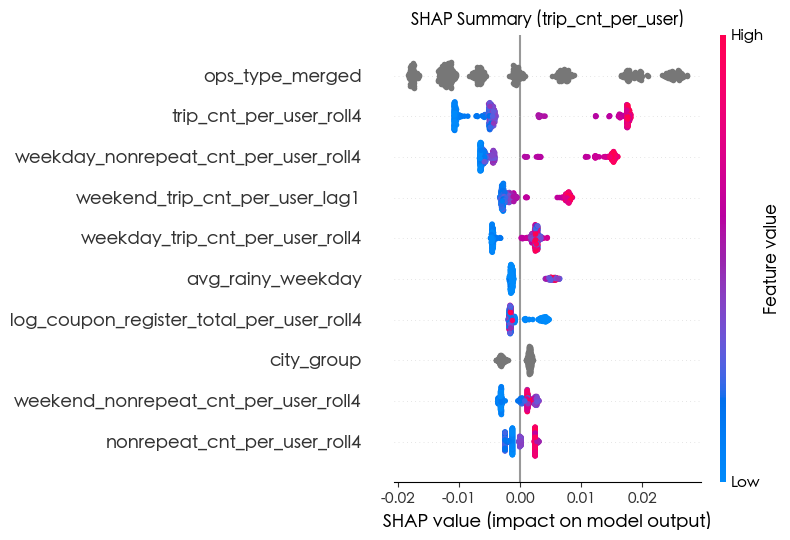

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_24183/2607421820.py:254: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_y1, X_shap, plot_type="bar", show=False, max_display=10)


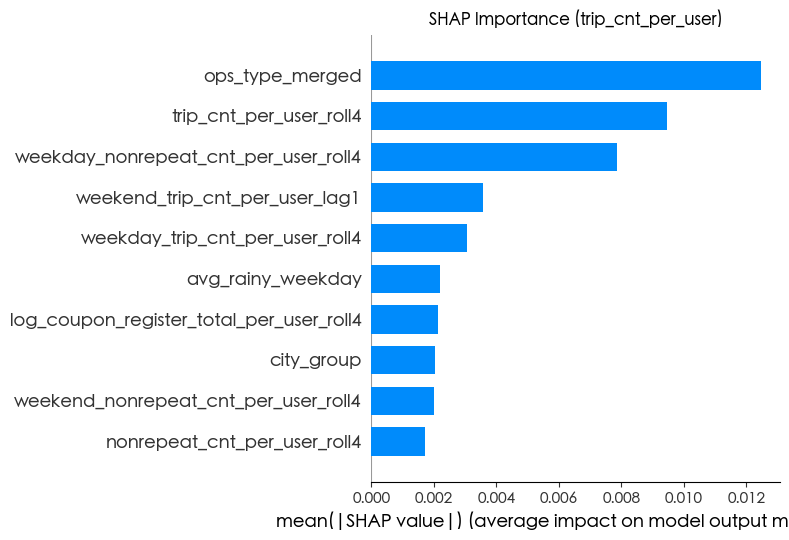

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_24183/2607421820.py:260: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_y2, X_shap, show=False, max_display=10)


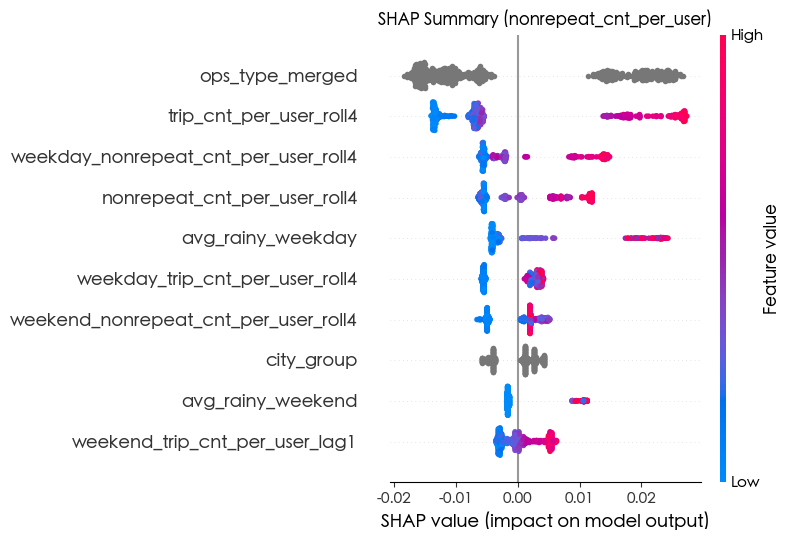

/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_24183/2607421820.py:266: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_y2, X_shap, plot_type="bar", show=False, max_display=10)


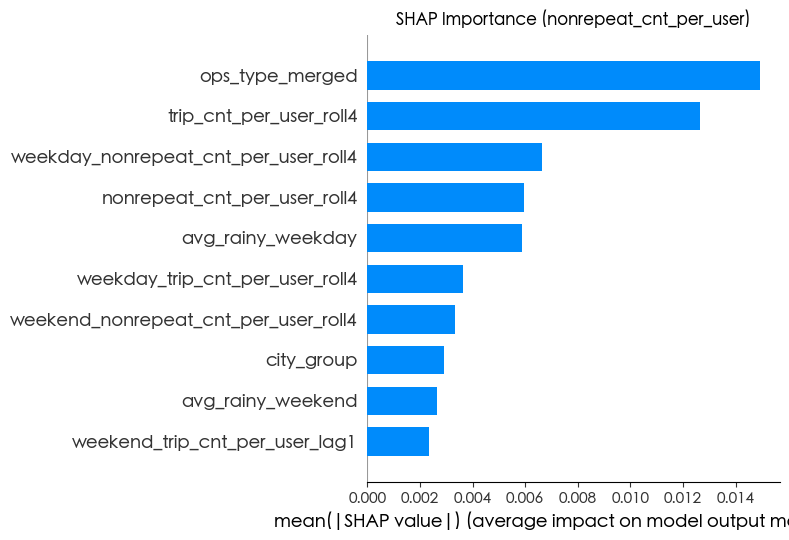

In [14]:
# ==========================================
# CONTROL: Global model (LGBM) + SHAP
# Make CONTROL use SAME categorical cols as RANDOM:
#   ["treatment","source","ops_type_merged","city_group"]
# Target week: 2026-01-05
# - Keep pipeline: auto-cast object->category + align categories
# - ONLY plot SHAP (no saving, no extra tables)
# ==========================================

import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_control.csv"
TARGET_WEEK = "2026-01-05"

DATE_COL = "experiment_date"
Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# ✅ Make CONTROL use SAME categorical cols as RANDOM
CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

DROP_FEATURES = {"log1p_user_cnt", "week_idx"}
RANDOM_STATE = 42

SHAP_SAMPLE_N = 20000  # None for full

# --------------------------
# Font (optional): Chinese labels
# --------------------------
def set_chinese_font():
    candidates = [
        "Noto Sans CJK TC", "Noto Sans CJK SC", "Noto Sans CJK JP",
        "PingFang TC", "Microsoft JhengHei", "Heiti TC",
        "WenQuanYi Zen Hei", "SimHei", "Arial Unicode MS",
    ]
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

set_chinese_font()
np.random.seed(42)

# --------------------------
# Helpers
# --------------------------
def make_time_val_split(train_df, date_col, n_val_weeks=4):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        cut = int(len(uniq_dates) * 0.8)
        cut = max(1, min(cut, len(uniq_dates) - 1))
        tr_dates = set(uniq_dates[:cut])
        va_dates = set(uniq_dates[cut:])
        tr = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(tr_dates)].copy()
        va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(va_dates)].copy()
        if tr.empty or va.empty:
            return train_df.copy(), None

    return tr, va

def assert_no_object_dtypes(X, name="X"):
    bad = X.dtypes[X.dtypes == "object"]
    if len(bad) > 0:
        raise ValueError(f"{name} still has object dtypes: {list(bad.index)}")

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

# week_idx (will be dropped later)
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_week = pd.to_datetime(TARGET_WEEK)
train = df[df[DATE_COL] < target_week].copy()
test  = df[df[DATE_COL] == target_week].copy()
if train.empty:
    raise ValueError("Train set is empty. TARGET_WEEK may be too early.")
if test.empty:
    raise ValueError(f"Test set is empty for week {TARGET_WEEK}. Check experiment_date values.")

# ✅ Ensure CONTROL has all categorical cols we want
missing_cats = [c for c in CAT_COLS if c not in df.columns]
if missing_cats:
    raise ValueError(f"CONTROL data is missing categorical cols required to match RANDOM: {missing_cats}")

# --------------------------
# Features: exclude y + drops (same style as your pipeline)
# --------------------------
exclude = {Y1, Y2} | set(DROP_FEATURES)
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

# --------------------------
# Cast categorical cols + any object cols
# --------------------------
X_all = df[feature_cols].copy()

# Force these CAT_COLS to category (even if numeric/string)
for c in CAT_COLS:
    X_all[c] = X_all[c].astype("category")

# Also convert remaining object columns to category (optional but safe)
obj_cols = X_all.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X_all[c] = X_all[c].astype("category")

cat_features = X_all.select_dtypes(include=["category"]).columns.tolist()

X_train = X_all.loc[train.index].copy()
X_test  = X_all.loc[test.index].copy()

# align categories using global categories from X_all
for c in cat_features:
    union_cats = X_all[c].cat.categories
    X_train[c] = X_train[c].cat.set_categories(union_cats)
    X_test[c]  = X_test[c].cat.set_categories(union_cats)

assert_no_object_dtypes(X_train, "X_train")
assert_no_object_dtypes(X_test, "X_test")

y1_train = train[Y1].astype(float).values
y2_train = train[Y2].astype(float).values

# --------------------------
# Val split for early stopping
# --------------------------
tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=4)
X_tr = X_all.loc[tr_df.index].copy()
for c in cat_features:
    X_tr[c] = X_tr[c].cat.set_categories(X_all[c].cat.categories)
y1_tr = tr_df[Y1].astype(float).values
y2_tr = tr_df[Y2].astype(float).values

X_va = None
y1_va = y2_va = None
if va_df is not None and (not va_df.empty):
    X_va = X_all.loc[va_df.index].copy()
    for c in cat_features:
        X_va[c] = X_va[c].cat.set_categories(X_all[c].cat.categories)
    y1_va = va_df[Y1].astype(float).values
    y2_va = va_df[Y2].astype(float).values

fit_kwargs = dict(categorical_feature=cat_features)

# --------------------------
# Params (your CONTROL tuned ones)
# --------------------------
base_params = dict(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

params_y1 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=80,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_split_gain=0.0,
)

params_y2 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=50,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=5.0,
    min_split_gain=0.01,
)

m_y1 = lgb.LGBMRegressor(**{**base_params, **params_y1})
m_y2 = lgb.LGBMRegressor(**{**base_params, **params_y2})

EARLY_STOP = 100

if X_va is not None:
    m_y1.fit(
        X_tr, y1_tr,
        eval_set=[(X_va, y1_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
    m_y2.fit(
        X_tr, y2_tr,
        eval_set=[(X_va, y2_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
else:
    m_y1.fit(X_train, y1_train, **fit_kwargs)
    m_y2.fit(X_train, y2_train, **fit_kwargs)

# --------------------------
# SHAP sample from TRAIN
# --------------------------
if SHAP_SAMPLE_N is None or SHAP_SAMPLE_N >= len(X_train):
    X_shap = X_train
else:
    X_shap = X_train.sample(SHAP_SAMPLE_N, random_state=42)

expl_y1 = shap.TreeExplainer(m_y1)
expl_y2 = shap.TreeExplainer(m_y2)

shap_values_y1 = expl_y1.shap_values(X_shap)
shap_values_y2 = expl_y2.shap_values(X_shap)

# --------------------------
# Plot SHAP (beeswarm + bar)
# --------------------------
plt.figure()
shap.summary_plot(shap_values_y1, X_shap, show=False, max_display=10)
plt.title("SHAP Summary (trip_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_y1, X_shap, plot_type="bar", show=False, max_display=10)
plt.title("SHAP Importance (trip_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_y2, X_shap, show=False, max_display=10)
plt.title("SHAP Summary (nonrepeat_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_y2, X_shap, plot_type="bar", show=False, max_display=10)
plt.title("SHAP Importance (nonrepeat_cnt_per_user)")
plt.tight_layout()
plt.show()
